This code is to fit a spectrum as the sum of two atmosphere models (a spot and a surface).

To do:
<br /> -Masking out bad regions a la Mann+2013
<br /> -Testing just NIR data
<br /> -Additional flux calibration corrections?

In [43]:
from astropy.modeling import models
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u

from scipy import interpolate
from scipy import stats
from scipy import optimize

import numpy as np

from specutils.fitting import fit_continuum
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum

import matplotlib.pyplot as plt

from multiprocessing import Pool

from emcee import EnsembleSampler
import emcee
import corner
import random

from gaussfold import gaussfold as gf
from IPython.display import display, Math

import multiprocessing as mp
Pool = mp.get_context('fork').Pool
from dust_extinction.parameter_averages import F19

# define the model
ext = F19(Rv=3.1)

In [44]:
plt.rcParams['lines.linewidth']   =3
plt.rcParams['axes.linewidth']    = 2
plt.rcParams['xtick.major.width'] =2
plt.rcParams['ytick.major.width'] =2
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelweight']='semibold'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['axes.titleweight']='semibold'
plt.rcParams['axes.titlesize']=9

In [45]:
num = 5
mask_optical = True
nir_only = True
whoami = 'mannaw'

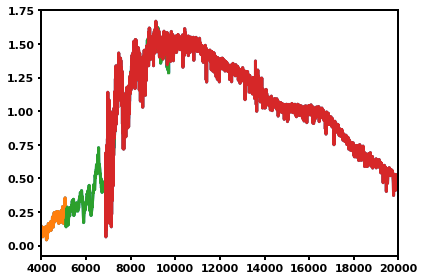

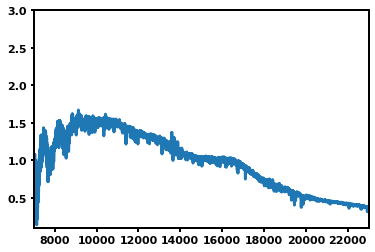

In [46]:
## read in data
obswav,obsspec,obserr,obstype = np.loadtxt('rawspec.txt',unpack=True,skiprows=1)

plt.plot(obswav,obsspec)
l1 = np.where(obstype == 1)
plt.plot(obswav[l1],obsspec[l1])
l2 = np.where(obstype == 2)
plt.plot(obswav[l2],obsspec[l2])
l3 = np.where(obstype == 3)
plt.plot(obswav[l3],obsspec[l3])
plt.xlim(4000,20000)
plt.tight_layout()
plt.show()

## this trims the bad region of the SpeX data (noisy)
l4 = np.where((obswav > 4000) & (obswav<24000) & ((obswav > 8000)|(obstype<3)) & (obsspec > 0))
opticalspec = obsspec[l4]
opticalwav = obswav[l4]
opticalerr = obserr[l4]
l5 = np.where((obswav > 4000) & (obswav<23500) & (obsspec/obserr > 10))
if mask_optical: ## if we want to cut the annoying region around 6300-6600
    l5 = np.where((obswav > 4000) & (obswav<23500) & (obsspec/obserr > 15) & ((obswav > 6600)|(obswav<6350)) & ((obswav > 6153)|(obswav<6056)) & ((obswav > 7020)|(obswav<6915)) & ((obswav > 7580)|(obswav<7700))   )
if nir_only:
    l5 = np.where((obstype == 3)&(obswav<23500))
## uncomment this when you want to run the fit without that nasty region in the optical

obsspec_cut = np.array(obsspec[l5])
obswav_cut = np.array(obswav[l5])
obserr_cut = np.array(obserr[l5])
obstype_cut = np.array(obstype[l5])

plt.plot(obswav_cut,obsspec_cut)
plt.tight_layout
plt.xlim(7000,23000)
plt.ylim(0.1,3)
plt.show()

In [47]:
modelpath = '/Users/'+whoami+'/Dropbox/Radii/Models_CIFIST_Dupuy.fits'
modelpath = '/Users/'+whoami+'/Dropbox/Radii/Models_K233_Feb2020.fits'
hdul = fits.open(modelpath)
hdul.info()
hdr = hdul[1].header
data = hdul[1].data

## trim the models to just solar metallicity and log(g) = 4.5
lambda0 = 4000
nlambda = 210001
dlambda = 0.1
modelwave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
modelteff = np.squeeze(data['teff'])
modellogg = np.squeeze(data['logg'])
modelafe = np.squeeze(data['a_fe'])
modelmh = np.squeeze(data['metal'])
modelspectra = np.squeeze(data['spectrum'])

modelwave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
ll = np.where((modelwave > 3000) & (modelwave < 53000))
modelspectra = np.squeeze(modelspectra[ll,:])
modelwave = modelwave[ll]

## resample model spectra to match input data
newlambda = np.array(obswav_cut)
newmodel = np.zeros((np.size(newlambda),np.size(modelteff)))
for i in range(0,np.size(modelteff)):
    tmp = np.array(modelspectra[:,i])
    interpfunc = interpolate.interp1d(modelwave, tmp, kind='linear',fill_value="extrapolate")
    modelspec_new = interpfunc(newlambda)
    ## not quite right. 5-10A is OK for optical (R~1000), but NIR should be R~2000 (10 at 10000 and 20 at 20000)
    ## tests indicate this is not a serious problem
    modelspec_new = gf(newlambda, modelspec_new, 8) 
    newmodel[:,i] = modelspec_new

modelwave = newlambda
modelspectra = newmodel

Filename: /Users/mannaw/Dropbox/Radii/Models_K233_Feb2020.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   1R x 7C   [3760A, 13650065E, 65E, 65E, 65E, 65E, 65E]   


In [48]:
def getspec(teffs,spectra, inteff): ##  for now other parameters are fixed
    loc = np.where(teffs == inteff)
    #print(inteff,np.shape(spectra),np.shape(teffs))
    above = np.min(np.where(teffs >= inteff))
    below = np.max(np.where(teffs < inteff))
    if np.size(below) < 1 or np.size(above) < 1:
        return(-np.inf)
    
    spec1 = np.squeeze(spectra[:,above])
    spec2 = np.squeeze(spectra[:,below])
    weight = (inteff-teffs[below])/(teffs[above]-teffs[below])
    spec = (1.-weight)*spec2 + weight*spec1
    #else:
    #    spec = np.squeeze(spectra[:,loc])
    return(spec)

## this will take two temperatures (spot and surf) 
##and a coverage fraction (fS) 
## and output the relevant spectrum
def doublespec(teffs,spectra, teff1,teff2,fS):
    spec1 = getspec(teffs,spectra,teff1)
    spec2 = getspec(teffs,spectra,teff2)
    spec = spec1*(1-fS) + spec2*fS
    return(spec)

## the likelihood needs to fit a few parameters:
## 1) Tsurf
## 2) Tspot 
## 3) small lambda offsets
## 4) flux calibration errors?
## 5) fS
## 6) ??
#define functions for MCMC
def ln_prior(theta):
    Tsurf, Tspot, fS, a, b, c, AV, loff, f = theta
    if AV > 1.5 or AV < 0.3 or (loff < -3) or (loff > 3) or (Tspot < 1500) or (Tspot > 4500) or (Tsurf < 1500) or (Tsurf > 4500) or fS < 0.0 or fS > 1.0 or f < 0 or f > 0.1 or Tspot>(Tsurf-100) or a/b >2 or a/b < 0.5 or a/c < 0.5 or a/c > 2:
        return -np.inf
    return 0

## warning, wavelengths for model spectra and observational data must match
def ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr ):
    Tsurf, Tspot, fS, a, b, c, AV, loff, f = theta
    modelspec = doublespec(modelteff,modelspectra,Tsurf,Tspot,fS)
    newwav = wav + loff
    interpfunc = interpolate.interp1d(wav, modelspec, kind='linear',fill_value="extrapolate")
    modelspec_shift = interpfunc(newwav)
    modelspec_smooth = modelspec_shift  
    reddened = modelspec_smooth*ext.extinguish(wav*u.AA, Av=AV)
        
    modelspec_norm = np.array(reddened)/np.mean(reddened)
    obsspec_norm = np.array(obsspec)/np.mean(obsspec)
    obsspec_err_norm = np.array(obserr)/np.mean(obsspec)
    obsspec_norm[np.where(obstype == 1)]*=a
    obsspec_norm[np.where(obstype == 2)]*=b
    obsspec_norm[np.where(obstype == 3)]*=c
    obsspec_err_norm[np.where(obstype == 1)]*=a
    obsspec_err_norm[np.where(obstype == 2)]*=b
    obsspec_err_norm[np.where(obstype == 3)]*=c    
    ## due to edge effects, we need to trim the first and last ~20 points
    diff = (modelspec_norm - obsspec_norm)
    s_squared = np.square(obsspec_err_norm) + np.square(f*obsspec_norm)
    p = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(diff) / (2. * s_squared)) 
    ## what if we just removed the 20 worst points instead?
    tmp = np.sort(p)
    #print(tmp)
    #print(tmp[int(np.round(np.size(tmp)*0.01)):np.size(tmp)])
    output = np.sum(np.log(tmp[int(np.round(np.size(tmp)*0.01)):np.size(tmp)]))
    #output = np.sum(np.log(p[20:np.size(modelspec_norm)-20]))
    return output

def ln_posterior(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr ):
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    ln_like = ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr )
    if not np.isfinite(ln_like):
        return -np.inf
    return ln_p + ln_like

In [49]:
def getspec(teffs,spectra, inteff): ##  for now other parameters are fixed
    loc = np.where(teffs == inteff)
    #print(inteff,np.shape(spectra),np.shape(teffs))
    above = np.min(np.where(teffs >= inteff))
    below = np.max(np.where(teffs < inteff))
    if np.size(below) < 1 or np.size(above) < 1:
        return(-np.inf)
    
    spec1 = np.squeeze(spectra[:,above])
    spec2 = np.squeeze(spectra[:,below])
    weight = (inteff-teffs[below])/(teffs[above]-teffs[below])
    spec = (1.-weight)*spec2 + weight*spec1
    #else:
    #    spec = np.squeeze(spectra[:,loc])
    return(spec)

## this will take two temperatures (spot and surf) 
##and a coverage fraction (fS) 
## and output the relevant spectrum
def doublespec(teffs,spectra, teff1,teff2,fS):
    spec1 = getspec(teffs,spectra,teff1)
    spec2 = getspec(teffs,spectra,teff2)
    spec = spec1*(1-fS) + spec2*fS
    return(spec)

## the likelihood needs to fit a few parameters:
## 1) Tsurf
## 2) Tspot 
## 3) small lambda offsets
## 4) flux calibration errors?
## 5) fS
## 6) ??
#define functions for MCMC
def ln_priorNIR(theta):
    Tsurf, Tspot, fS, a, AV, loff, f = theta
    if AV > 1.5 or AV < 0.3 or (loff < -3) or (loff > 3) or (Tspot < 1500) or (Tspot > 4500) or (Tsurf < 1500) or (Tsurf > 4500) or fS < 0.0 or fS > 1.0 or f < 0 or f > 0.1 or Tspot>(Tsurf-100):
        return -np.inf
    return 0

## warning, wavelengths for model spectra and observational data must match
def ln_likelihoodNIR(theta, modelteff, modelspectra, wav, obsspec, obserr ):
    Tsurf, Tspot, fS, a, AV, loff, f = theta
    modelspec = doublespec(modelteff,modelspectra,Tsurf,Tspot,fS)
    newwav = wav + loff
    interpfunc = interpolate.interp1d(wav, modelspec, kind='linear',fill_value="extrapolate")
    modelspec_shift = interpfunc(newwav)
    modelspec_smooth = modelspec_shift  
    reddened = modelspec_smooth*ext.extinguish(wav*u.AA, Av=AV)
        
    modelspec_norm = np.array(reddened)/np.mean(reddened)
    obsspec_norm = np.array(obsspec)/np.mean(obsspec)
    obsspec_err_norm = np.array(obserr)/np.mean(obsspec)
    obsspec_norm*=a
    obsspec_err_norm*=a
    diff = (modelspec_norm - obsspec_norm)
    s_squared = np.square(obsspec_err_norm) + np.square(f*obsspec_norm)
    p = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(diff) / (2. * s_squared)) 
    tmp = np.sort(p)
    output = np.sum(np.log(tmp[int(np.round(np.size(tmp)*0.01)):np.size(tmp)]))
    return output

def ln_posteriorNIR(theta, modelteff, modelspectra, wav, obsspec, obserr ):
    ln_p = ln_priorNIR(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    ln_like = ln_likelihoodNIR(theta, modelteff, modelspectra, wav, obsspec, obserr )
    if not np.isfinite(ln_like):
        return -np.inf
    return ln_p + ln_like

In [50]:
### do not delete
#fig, ax = plt.subplots()
#fig.set_size_inches(6, 3)

#alpha = 0.8
## here let's make some example spectra to show off why this method works
#modelwave = obswav_cut
#norm = np.where((modelwave < 8000)&(modelwave>7000))
#spec1 = doublespec(modelteff,modelspectra,3540,2800,0.2)
#plt.plot(modelwave/1e4,spec1/np.median(spec1[norm]),label='20% spots',alpha=alpha,color='black')
#spec2 = doublespec(modelteff,modelspectra,3540,2800,0.5)
#plt.plot(modelwave/1e4,spec2/np.median(spec2[norm]),label='50% spots',alpha=alpha,color='blue')
#spec3 = doublespec(modelteff,modelspectra,3540,2800,0.8)
#plt.plot(modelwave/1e4,spec3/np.median(spec3[norm]),label='80% spots',alpha=alpha,color='green')

#plt.tight_layout
#plt.xlim(0.6,2.0)
#ax.set_ylim(0.2,1.75)
#plt.legend()
#ax.set_ylabel(r'Normalized Flux')
#ax.set_xlabel(r'Wavelength ($\mu m$)')
#plt.tight_layout()
#plt.savefig('Example_spots_lowres.pdf')

In [51]:
obsspec_cut = np.array(obsspec[l5])
obswav_cut = np.array(obswav[l5])
obserr_cut = np.array(obserr[l5])
obstype_cut = np.array(obstype[l5])
#plt.plot(modelwave,obsspec_cut)
#plt.show()
#testspec = doublespec(modelteff,modelspectra,3540,2900,0.55)
#red = ext.extinguish(modelwave*u.AA, Av=0.5)
#testspec *= red
#obsspec_plot = obsspec_cut/(np.median(obsspec_cut)/np.median(testspec))
#plt.plot(modelwave,obsspec_plot,label='obsspec')
#plt.plot(modelwave,testspec,label='testspec')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(4000,25000)
#plt.legend()
#plt.show()

In [52]:
nwalkers, ndim = 64, 9
nthreads = 12
ospec = np.array(list(obsspec_cut))
otype = np.array(list(obstype_cut))
oerr = np.array(list(obserr_cut))
mspec = np.array(list(modelspectra))
mteff = np.array(list(modelteff))
mwav = np.array(list(modelwave))

if nir_only:
    nwalkers, ndim = 64, 7
    print('if this is inf, we have a problem:')
    initial_guesses = [3500, 2500, 0.3, 1, 0.6, -1, 0.04]
    print(ln_posteriorNIR(initial_guesses,mteff,mspec,mwav,ospec,oerr))
    pos0 = []
    print('initializing walkers: (if you see a lot if inf, break this)')
    randomizer = [200, 200, 0.2, 0.001, 0.01, 0.1, 0.01]
    while len(pos0) < nwalkers:
        trial = initial_guesses + randomizer * np.random.randn(ndim)
        lp = ln_posteriorNIR(trial,mteff,mspec,mwav,ospec,oerr)
        print(lp)
        if np.isfinite(lp):
            pos0.append(trial)    
if not nir_only:
    print('running full spectrum')
    print('if this is inf, we have a problem:')
    initial_guesses = [3500, 2500, 0.3, 1,1,1, 0.6, -1, 0.04]
    print(ln_posterior(initial_guesses,mteff,mspec,mwav,ospec,otype,oerr))
    pos0 = []
    print('initializing walkers: (if you see a lot if inf, break this)')
    randomizer = [200, 200, 0.2, 0.001, 0.001, 0.001, 0.01, 0.1, 0.01]
    while len(pos0) < nwalkers:
        trial = initial_guesses + randomizer * np.random.randn(ndim)
        lp = ln_posterior(trial,mteff,mspec,mwav,ospec,otype,oerr)
        print(lp)
        if np.isfinite(lp):
            pos0.append(trial)

if this is inf, we have a problem:
11156.17455165548
initializing walkers: (if you see a lot if inf, break this)
10714.633281396475
-8600.951174060716
-59771.691600497055
-715.6723778033838
10872.883724481599
6167.70366463716
-inf
1036.49153716831
9499.64185735517
11647.103200634454
11403.41335939959
5363.26617518251
11172.655615184693
5391.201197975475
455.4349747306187
9655.89838375444
11499.215053202744
-24669.05854828266
10845.13883563509
-68936.98285134048
9776.190365072436
10888.79003518861
-33204.33596433032
-66458.9251609708
8735.060665652505
-1062.306992774771
-53274.625223172035
-3951.6017736244803
10070.290482254772
10931.617468477627
3880.904082326978
10662.720566089187
-12430.732116515972
2009.2894346538533
8383.882203233003
-3111.3690031419246
5137.953104588843
6000.950082402052
6962.419101771505
9069.876069490563
11154.05488117107
11038.873540408238
-inf
-5200.4894997146275
5857.988402728295
9708.743929421405
8462.94780396813
1651.3210726460456
11075.242109680374
-1884.8

In [ ]:
nsteps = 100000
burn = 10000
thin = 10
if nir_only:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posteriorNIR, args=(mteff,mspec,mwav,ospec,oerr), threads=nthreads)
    sampler.run_mcmc(pos0, nsteps,progress=True)
if not nir_only:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(mteff,mspec,mwav,ospec,otype,oerr), threads=nthreads)
    sampler.run_mcmc(pos0, nsteps,progress=True)
    
print('done')

 78%|███████▊  | 77851/100000 [3:14:34<57:36,  6.41it/s]  

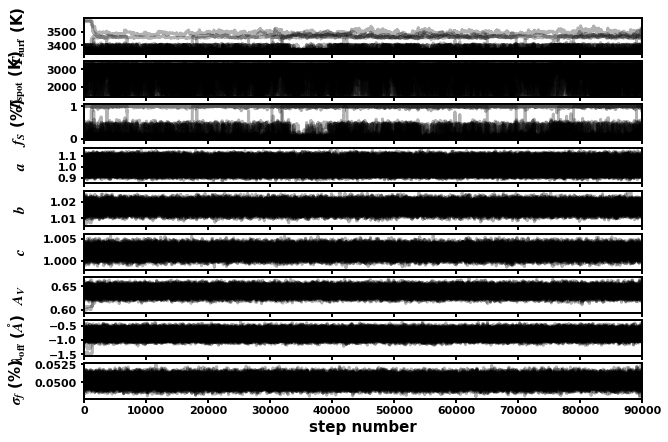

In [11]:
labels = [r'$T_{\rm{surf}}$ (K)',r'$T_{\rm{spot}}$ (K)',r'$f_S$ (%)',r'$a$',r'$b$',r'$c$','$A_V$',r'$\lambda_{\rm{off}}$ ($\AA$)',r'$\sigma_f$ (%)']
if nir_only:
    labels = [r'$T_{\rm{surf}}$ (K)',r'$T_{\rm{spot}}$ (K)',r'$f_S$ (%)',r'$a$','$A_V$',r'$\lambda_{\rm{off}}$ ($\AA$)',r'$\sigma_f$ (%)']

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burn)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
#plt.show()
plt.savefig('Walkers_specfit'+str(num)+'.pdf')

(576000, 9)


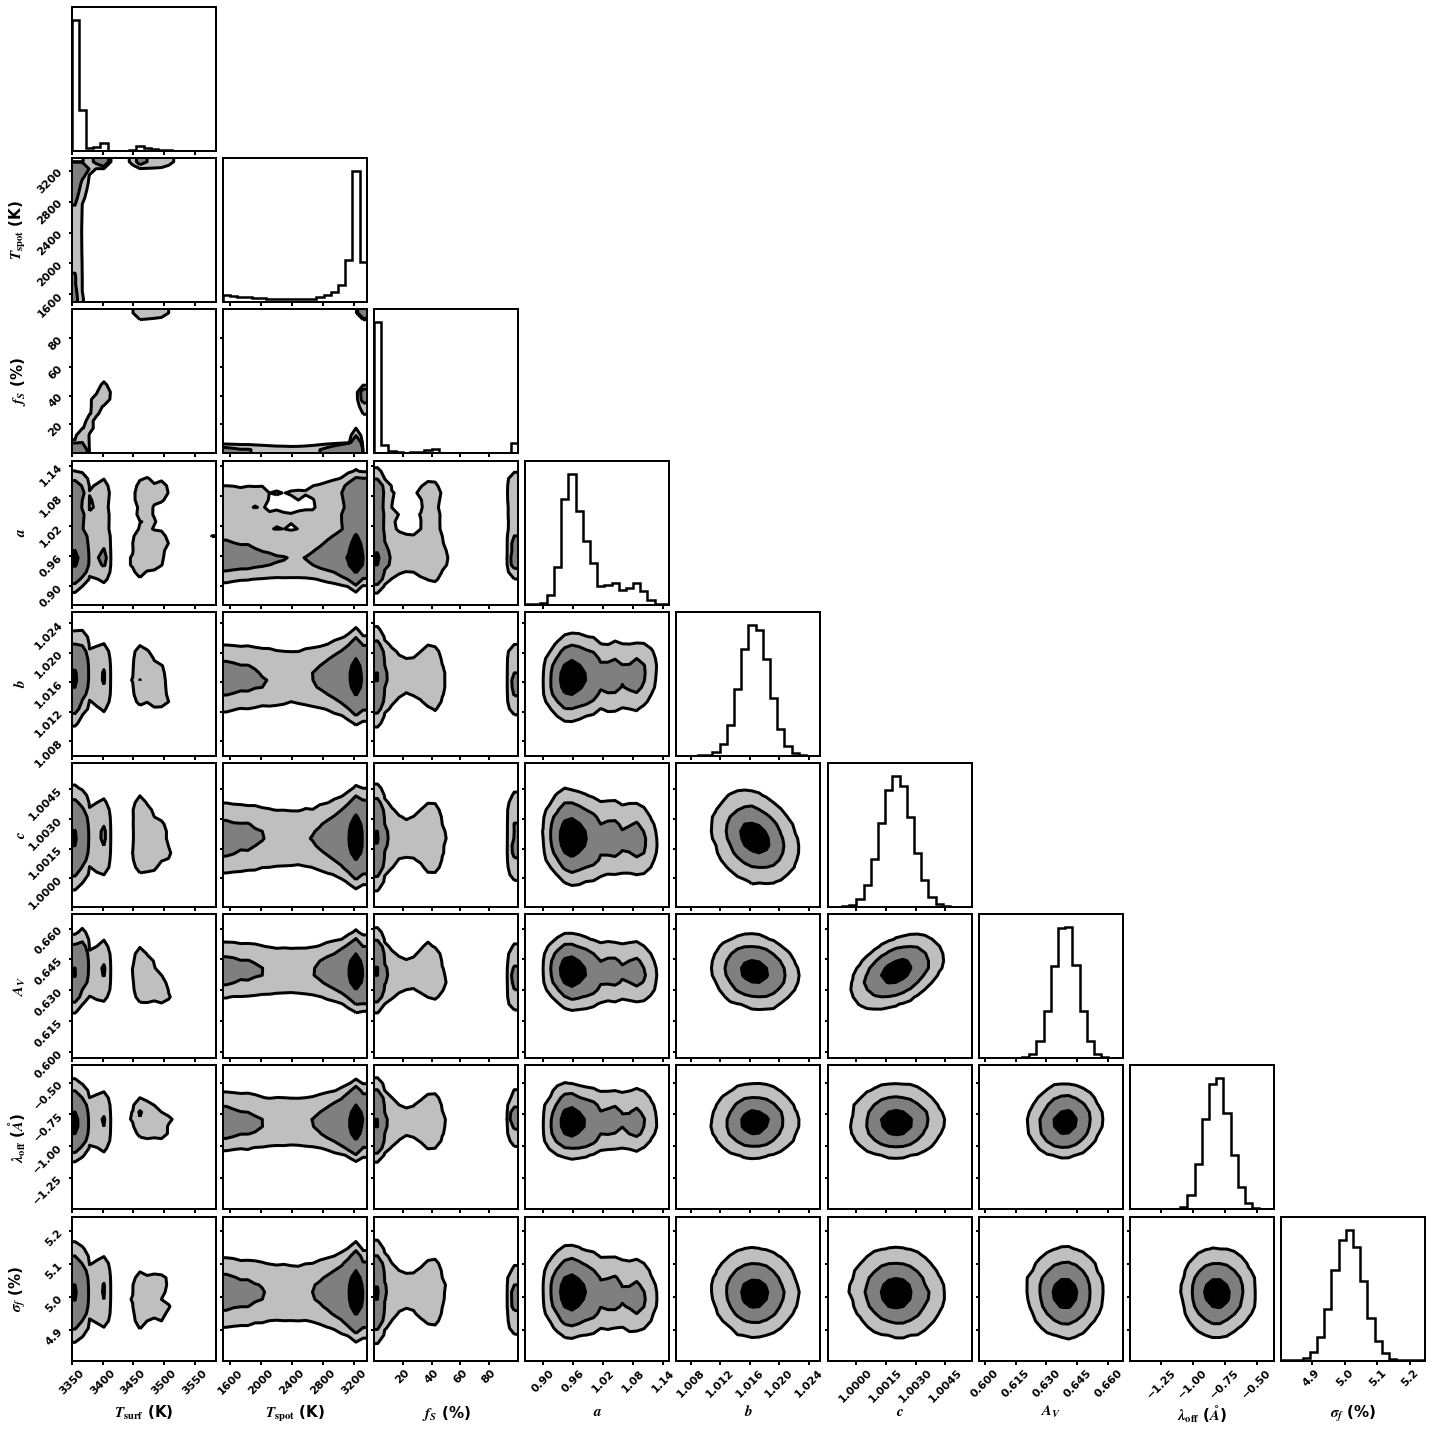

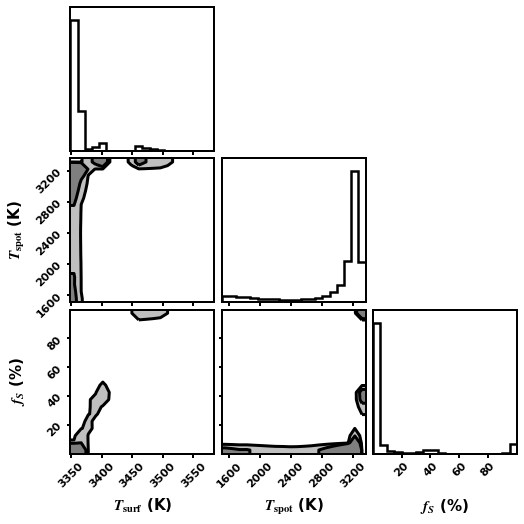

In [12]:
flat = np.array(sampler.get_chain(discard=burn, thin=thin, flat=True))
flat_samples = np.array(flat)
flat_samples[:,2]*=100
flat_samples[:,8]*=100
print(flat_samples.shape)
fig = corner.corner( 
    flat_samples, labels=labels, show_titles=False,
    fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.4f',
    hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
);

#plt.show()
plt.savefig('Corner_spec_lowres'+str(num)+'.pdf')


flat = np.array(sampler.get_chain(discard=burn, thin=thin, flat=True))
flat_samples = np.array(flat)
flat_samples[:,2]*=100
flat_samples[:,8]*=100
prob = sampler.get_log_prob(flat=True,thin=thin,discard=burn)
trimmed_flat = flat_samples[:,0:3]
trimmed_labels = labels[0:3]
fig = corner.corner( 
    trimmed_flat, labels=trimmed_labels, show_titles=False,
    fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.2f',
    hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
);

#plt.show()
plt.savefig('Corner_spec_lowres_trim'+str(num)+'.pdf')

In [13]:
np.save('Multispec_snifs'+str(num)+'_chain.npy', np.array(sampler.chain))
np.save('Multispec_snifs'+str(num)+'_prob.npy', np.array(sampler.lnprobability))
np.save('Multispec_snifs'+str(num)+'_accept.npy',np.array(sampler.acceptance_fraction))

In [14]:
## report best-fit parameters
## this current grabs the 50% one, but that's wrong, we want the highest likelihood

best = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
print('--------')
for i in range(ndim):
    b = np.squeeze(flat_samples[np.where(prob == np.max(prob)),i])
    if np.size(b) > 1:
        b = np.squeeze(b)
        b = b[0]
    best.append(b)
    print(labels[i],b)

best = np.squeeze(best)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------
$T_{\rm{surf}}$ (K) 3358.045653201287
$T_{\rm{spot}}$ (K) 3223.6243370725265
$f_S$ (%) 0.11593898046313611
$a$ 0.9599875445951714
$b$ 1.0170074304338992
$c$ 1.0022719114542469
$A_V$ 0.6396120919005567
$\lambda_{\rm{off}}$ ($\AA$) -0.7973641715187932
$\sigma_f$ (%) 5.004656008241587


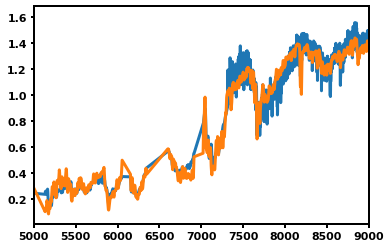

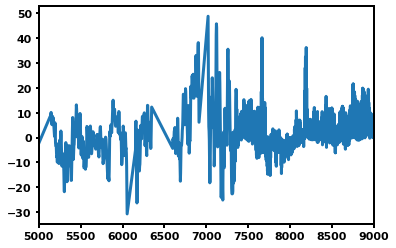

[ 5304.78  6052.13  6055.06  6172.29  6175.22  6817.06  6828.78  6831.71
  6834.65  6843.44  6846.37  6872.75  6875.68  6878.61  6881.54  6884.47
  6887.4   6896.19  6899.12  6902.05  6904.98  6907.92  7022.22  7025.15
  7072.04  7074.97  7116.    7118.93  7121.86  7124.79  7127.72  7157.03
  7159.96  7162.89  7177.55  7180.48  7195.13  7198.06  7253.75  7256.68
  7259.61  7262.54  7265.47  7274.26  7277.19  7303.57  7306.5   7309.43
  7312.36  7315.29  7318.23  7661.13  7664.06  7666.99  7669.92  8182.81
  8185.74  8188.67  8191.6   8194.53  8197.46  8754.31  8757.24 19412.19
 19415.8  19707.86 19711.47 20391.61 20395.21 23235.39 23238.97 23242.54
 23499.87]


In [16]:
mteff = modelteff
modelspectra = mspec
wav = np.array(mwav)
obsspec = np.array(ospec)
obstype = np.array(otype)
obserr = np.array(oerr)
Tsurf, Tspot, fS, a, b, c, AV, loff, f = best
modelspec = doublespec(mteff,modelspectra,Tsurf,Tspot,fS)
newwav = wav + loff
interpfunc = interpolate.interp1d(newwav, modelspec, kind='linear',fill_value="extrapolate")
modelspec_shift = interpfunc(wav)
modelspec_smooth = modelspec_shift  
reddened = modelspec_smooth*ext.extinguish(wav*u.AA, Av=AV)
    
modelspec_norm = np.array(reddened)/np.mean(reddened)
obsspec_norm = np.array(obsspec)/np.mean(obsspec)
obsspec_err_norm = np.array(obserr)/np.mean(obsspec)    
obsspec_norm[np.where(obstype == 1)]*=a
obsspec_norm[np.where(obstype == 2)]*=b
obsspec_norm[np.where(obstype == 3)]*=c
obsspec_err_norm[np.where(obstype == 1)]*=a
obsspec_err_norm[np.where(obstype == 2)]*=b
obsspec_err_norm[np.where(obstype == 3)]*=c  

plt.plot(wav,obsspec_norm)
plt.plot(wav,modelspec_norm)
plt.xlim(5000,9000)
plt.show()

plt.plot(wav,(obsspec_norm-modelspec_norm)/obsspec_err_norm)
plt.xlim(5000,9000)#6050-6175
plt.show()

off = np.abs((obsspec_norm-modelspec_norm)/obsspec_err_norm)
print(wav[np.where(off > 20)])